<a href="https://colab.research.google.com/github/abdelmonem808/Artificial-Intelligence-and-Machine-Vision/blob/main/Vehicles-License-Plate-Detection-using-Deep-Learning-and-Computer-Vision-Techniques/model_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
!pip install pytesseract

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [15]:
!rm -r /content/Artificial-Intelligence-and-Machine-Vision

In [16]:
!git clone https://github.com/abdelmonem808/Artificial-Intelligence-and-Machine-Vision
path = '/content/Artificial-Intelligence-and-Machine-Vision/Vehicles-License-Plate-Detection-using-Deep-Learning-and-Computer-Vision-Techniques/images'

%cd urldata #go to the directory where git clone says *Cloning into*

for subdir, dirs, files in os.walk(path):
  print(files)

Cloning into 'Artificial-Intelligence-and-Machine-Vision'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 135 (delta 3), reused 0 (delta 0), pack-reused 124
Receiving objects: 100% (135/135), 21.93 MiB | 22.32 MiB/s, done.
Resolving deltas: 100% (60/60), done.
[Errno 2] No such file or directory: 'urldata #go to the directory where git clone says *Cloning into*'
/content
['Cars35.png', 'Cars24.png', 'Cars29.xml', 'Cars15.png', 'Cars25.xml', 'Cars26.xml', 'Cars42.xml', 'Cars2.xml', 'Cars21.png', 'Cars5.png', 'Cars11.png', 'Cars31.png', 'Cars42.png', 'Cars41.png', 'Cars23.xml', 'Cars38.png', 'Cars46.png', 'Cars3.xml', 'Cars40.png', 'Cars20.png', 'Cars39.xml', 'Cars41.xml', 'Cars47.png', 'Cars19.xml', 'Cars8.png', 'test.png', 'Cars13.png', 'Cars14.xml', 'Cars13.xml', 'Cars31.xml', 'Cars32.png', 'Cars19.png', 'Cars7.png', 'Cars14.png', 'Cars47.xml', 'Cars10.png', 'Cars33.png', 'Cars37.xm

In [17]:
path = glob('/content/Artificial-Intelligence-and-Machine-Vision/Vehicles-License-Plate-Detection-using-Deep-Learning-and-Computer-Vision-Techniques/images/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [36]:
df = pd.DataFrame(labels_dict)
df.to_csv('../labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,/content/Artificial-Intelligence-and-Machine-V...,143,211,171,208
1,/content/Artificial-Intelligence-and-Machine-V...,177,216,139,159
2,/content/Artificial-Intelligence-and-Machine-V...,258,321,184,213
3,/content/Artificial-Intelligence-and-Machine-V...,177,217,140,159
4,/content/Artificial-Intelligence-and-Machine-V...,229,270,176,193


In [19]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('/content/Artificial-Intelligence-and-Machine-Vision/Vehicles-License-Plate-Detection-using-Deep-Learning-and-Computer-Vision-Techniques/images',filename_image)
    return filepath_image
getFilename(filename)

'/content/Artificial-Intelligence-and-Machine-Vision/Vehicles-License-Plate-Detection-using-Deep-Learning-and-Computer-Vision-Techniques/images/Cars29.png'

In [22]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['/content/Artificial-Intelligence-and-Machine-Vision/Vehicles-License-Plate-Detection-using-Deep-Learning-and-Computer-Vision-Techniques/images/Cars29.png',
 '/content/Artificial-Intelligence-and-Machine-Vision/Vehicles-License-Plate-Detection-using-Deep-Learning-and-Computer-Vision-Techniques/images/Cars25.png',
 '/content/Artificial-Intelligence-and-Machine-Vision/Vehicles-License-Plate-Detection-using-Deep-Learning-and-Computer-Vision-Techniques/images/Cars26.png',
 '/content/Artificial-Intelligence-and-Machine-Vision/Vehicles-License-Plate-Detection-using-Deep-Learning-and-Computer-Vision-Techniques/images/Cars42.png',
 '/content/Artificial-Intelligence-and-Machine-Vision/Vehicles-License-Plate-Detection-using-Deep-Learning-and-Computer-Vision-Techniques/images/Cars2.png',
 '/content/Artificial-Intelligence-and-Machine-Vision/Vehicles-License-Plate-Detection-using-Deep-Learning-and-Computer-Vision-Techniques/images/Cars23.png',
 '/content/Artificial-Intelligence-and-Machine-Vision


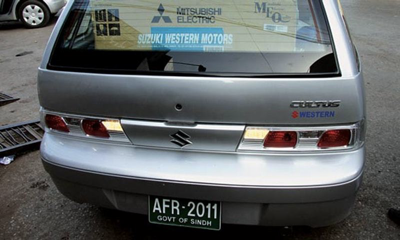

In [35]:
file_path = image_path[9] #path of our image
img = cv2.imread(file_path) #read the image
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure with bounding box')
fig.add_shape(type='rect',x0=143, x1=211, y0=171, y1=171, xref='x', yref='y',line_color='cyan')

In [37]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [38]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [39]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((40, 224, 224, 3), (10, 224, 224, 3), (40, 4), (10, 4))

In [40]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

219055592/219055592 [==============================] - 2s 0us/step


In [41]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [43]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=10,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/10
4/4 [==============================] - 45s 11s/step - loss: 0.0151 - val_loss: 0.0198
Epoch 2/10
4/4 [==============================] - 45s 11s/step - loss: 0.0092 - val_loss: 0.0178
Epoch 3/10
4/4 [==============================] - 44s 11s/step - loss: 0.0089 - val_loss: 0.0193
Epoch 4/10
4/4 [==============================] - 44s 11s/step - loss: 0.0088 - val_loss: 0.0140
Epoch 5/10
4/4 [==============================] - 44s 11s/step - loss: 0.0064 - val_loss: 0.0113
Epoch 6/10
4/4 [==============================] - 45s 12s/step - loss: 0.0054 - val_loss: 0.0126
Epoch 7/10
4/4 [==============================] - 44s 11s/step - loss: 0.0040 - val_loss: 0.0111
Epoch 8/10
4/4 [==============================] - 47s 12s/step - loss: 0.0032 - val_loss: 0.0112
Epoch 9/10
4/4 [==============================] - 44s 11s/step - loss: 0.0037 - val_loss: 0.0123
Epoch 10/10
4/4 [==============================] - 46s 12s/step - loss: 0.0033 - val_loss: 0.0110


In [46]:
model.save('./Artificial-Intelligence-and-Machine-Vision/Vehicles-License-Plate-Detection-using-Deep-Learning-and-Computer-Vision-Techniques/object_detection.h5')

In [47]:
# Load model
model = tf.keras.models.load_model('./Artificial-Intelligence-and-Machine-Vision/Vehicles-License-Plate-Detection-using-Deep-Learning-and-Computer-Vision-Techniques/object_detection.h5')
print('Model loaded Sucessfully')

Model loaded Sucessfully


In [48]:
path = '/content/Artificial-Intelligence-and-Machine-Vision/Vehicles-License-Plate-Detection-using-Deep-Learning-and-Computer-Vision-Techniques/images/Cars0.png'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)

Height of the image = 268
Width of the image = 500



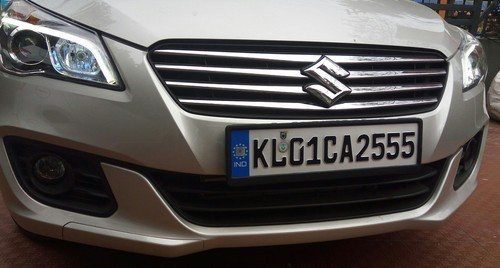

In [49]:
fig = px.imshow(image)
fig.update_layout(width=700, height=500,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure 13 - TEST Image')

In [50]:
image_arr_224.shape

(224, 224, 3)

In [51]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [52]:
# Make predictions
coords = model.predict(test_arr)
coords

1/1 [==============================] - 5s 5s/step


array([[0.38813138, 0.69361967, 0.58396316, 0.7001571 ]], dtype=float32)

In [53]:
# Denormalize the values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[194.06569004, 346.80983424, 156.50212574, 187.64210439]])

In [54]:
coords = coords.astype(np.int32)
coords

array([[194, 346, 156, 187]], dtype=int32)

In [55]:
# Draw bounding on top the image
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(194, 156) (346, 187)



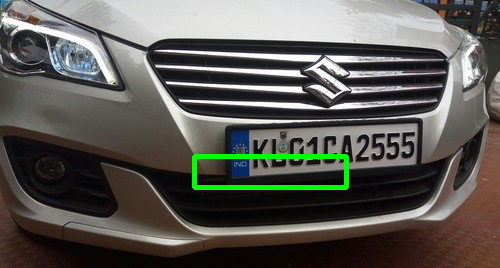

In [56]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))

1/1 [==============================] - 1s 687ms/step
(194, 156) (346, 187)



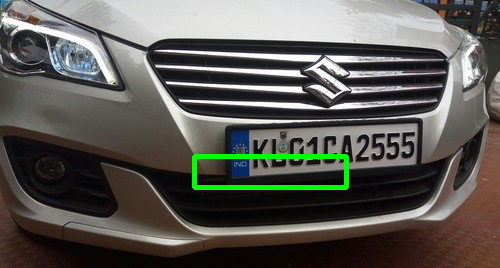

In [57]:
# Create pipeline
path = '/content/Artificial-Intelligence-and-Machine-Vision/Vehicles-License-Plate-Detection-using-Deep-Learning-and-Computer-Vision-Techniques/images/Cars0.png'
def object_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    coords = model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 14')

In [59]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 15 Cropped image')

In [62]:
# extract text from image
text = pt.image_to_string(roi)
print(text)

TesseractNotFoundError: ignored